<a href="https://colab.research.google.com/github/minhducvo04/PyTorch-models/blob/main/PyTorch_Computer_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch Computer Vision

In [ ]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from torch import nn
import torchvision
from torchvision import datasets
from torchvision import models
from torchvision import transforms
from torchvision.transforms import ToTensor 
from torchvision import datasets
from torch.utils.data import DataLoader

In [ ]:
# Device agnoistic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## Computer vision libraries in PyTorch

* `torchvision` - base domain library for PyTorch computer vision
* `torchvision.datasets` - get datasets and data loading functions for computer vision here
* `torchvision.models` - get pretrained computer vision models that you can leverage for your own problems
* `torchvision.transforms` - manipulate your vision data (images) to be suitable for use with a ML model
* `torch.utils.data.Dataset` - Base dataset class for PyTorch.
* `torch.utils.data.DataLoader` - Creates a Python iterable over a dataset

## Get dataset:
The data being used is FashionMNIST

In [ ]:
# Setup training data
train_data = datasets.FashionMNIST(
    root="data", #Where to download data to
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor(), #How do we want to transform the data
    target_transform=None
)
test_data = datasets.FashionMNIST(
    root="data", #Where to download data to
    train=False,
    download=True,
    transform=ToTensor(), #How do we want to transform the data
    target_transform=None
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [ ]:
len(train_data),len(test_data)

(60000, 10000)

In [ ]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [ ]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [ ]:
train_data.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

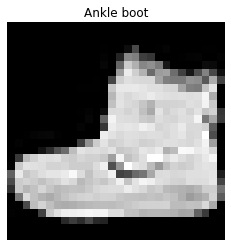

In [ ]:
image, label = train_data[0]
plt.imshow(image.squeeze(), cmap = "gray")
plt.title(class_names[label]);
plt.axis(False);

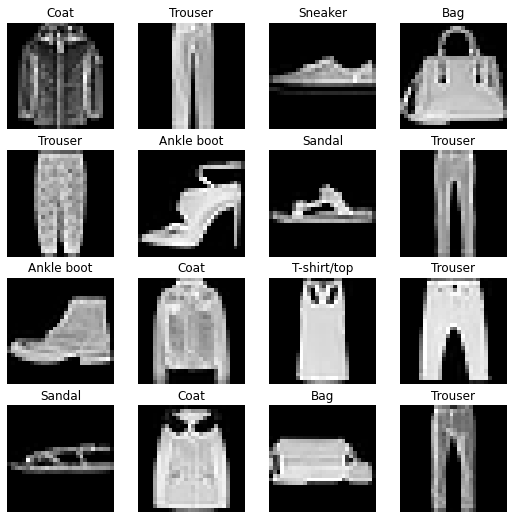

In [ ]:
#torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))
rows, cols = 4,4
for i in range(1, rows*cols+1):
  random_idx = torch.randint(0,len(train_data),size=[1]).item()
  #print(random_idx)
  image, label = train_data[random_idx]
  fig.add_subplot(rows,cols,i)
  plt.imshow(image.squeeze(), cmap="gray")
  plt.axis(False);
  plt.title(class_names[label]);

In [ ]:
train_data,test_data

(Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: ToTensor(), Dataset FashionMNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: ToTensor())

## Prepare DataLoader
Right now, our data is PyTorch Datasets

DataLoader will help to transform the data into PyTorch iterable

Specifically, we will turn the data into batches (or mini-batches)

Because our model cannot learn 60k datasets concurrently so break it down to 32 images at a time -> our model has more chances to update its gradients per epoch




In [ ]:
#Set up batch-size hyperparameter
BATCH_SIZE=32

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7fd784ff5220>,
 <torch.utils.data.dataloader.DataLoader at 0x7fd784ff50a0>)

In [ ]:
#Number of batches
len(train_dataloader), len(test_dataloader)

(1875, 313)

In [ ]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

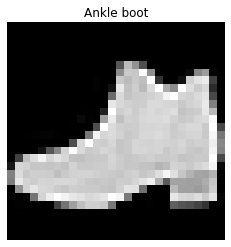

In [ ]:
random_idx = torch.randint(0,len(train_features_batch),size=[1]).item()
#print(random_idx)
image, label = train_data[random_idx]
plt.imshow(image.squeeze(), cmap="gray")
plt.axis(False);
plt.title(class_names[label]);

## Model 0: Build a baseline model
When starting to build a series of machine learning modelling experiment, it is best start with a baseline model.

A baseline model is a simple model you will try and improve upon with subsequent models/ experiments.

In other words, start simply and add complexity later on.

In [ ]:
# Create a flatten layer
flatten_model = nn.Flatten()

# Get simple model
x = train_features_batch[0]
x.shape

# Flatten the sample
output = flatten_model(x)
output.shape, x.shape

(torch.Size([1, 784]), torch.Size([1, 28, 28]))

In [ ]:
class FashionMNISTModelV0(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape,
                  out_features=hidden_units),
        #nn.ReLU(),
        nn.Linear(in_features=hidden_units,
                  out_features=hidden_units),
        #nn.ReLU(),
        nn.Linear(in_features=hidden_units,
                  out_features=output_shape)
    )
  def forward(self,x):
    return self.layer_stack(x)

In [ ]:
torch.manual_seed(42)

# Setup model with input parameters
model_0 = FashionMNISTModelV0(
    input_shape=784, # 28*28
    hidden_units=10, # units in hidden layers
    output_shape=len(class_names) 
).to(device)
model_0

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): Linear(in_features=10, out_features=10, bias=True)
  )
)

## Setup loss, optimizer, and evaluation metrics

* Loss function - Since we are working with multi-class classification, our loss function will be `nn.CrossEntropyLoss()`
* Optimizer - Our optimizer will be `nn.SGD()`
* Evaluation metrics - Let's use accuracy for evaluation metrics

In [ ]:
 # Calculate accuracy - what percentage does the model get right?
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

In [ ]:
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),
                   lr = 0.03)

## Create a funtion to to time our experiment

Machine learning is very experimental

Two main things you want to track here:
1. Performace (test loss and accuracy)
2. Time it takes



In [ ]:
from timeit import default_timer as timer 
start_time = timer()
def train_time(start: float,
                     end: float,
                     device: torch.device = None):
  total_time = end - start
  return total_time
def print_train_time(start:float,
                     end:float,
                     device:torch.device = None):
  print(f"Train time on {device}: {train_time(start=start,end=end,device=device):.3f} seconds")
end_time = timer()
print_train_time(start=start_time,end=end_time,device="cpu")

Train time on cpu: 0.002 seconds


## Create a training loop and training a model on batches of data
1. Loop through epochs
2. Loop through training batches, performing training steps, calculate the train loss *per batch*
3. Loop through testing batches, performing testing steps, calculate the test loss *per batch*
4. Print out what's happening
5. Time it all (for fun)

In [ ]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

rows, cols = 5,5
# Setup the seed and start the timer
torch.manual_seed(42)
train_timer_start = timer()
#show = 111 #torch.randint(119,124,size=[1]).item()
#id = 12 #torch.randint(0,31,size=[1]).item()

# Set the number of epochs (let it small for faster running time)
epochs = 4
# Create training and test loop
for epoch in tqdm(range(epochs)):
  #fig = plt.figure(figsize=(12.5,12.5))
  #i = 1
  #j = 1
  print(f"Epoch: {epoch}`n------")
  ### Training
  train_loss = 0
  # Add a loop through training batches
  for batch, (X,y) in enumerate(train_dataloader):
    X,y=X.to(device),y.to(device)
    model_0.train()
    # 1. Forward pass
    y_pred = model_0(X)

    # 2. Calculate the loss
    loss = loss_fn(y_pred, y)
    train_loss = train_loss + loss #Accumulate train loss

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Print out what's happening
    
    #if batch % 78 == 0:
    #  image, label = X[id], y[id]
    #  fig.add_subplot(rows,cols,i)
    #  plt.imshow(image.squeeze(), cmap = "gray")
    #  plt.axis(False);
    #  l = class_names[y_pred[id].argmax(dim=0)]
    #  plt.title(f"{l}({class_names[label]})");
    #  i = i + 1
    
    #if batch % 370 == 0:
      #print(f"Looked at batch {batch*len(X)}/{len(train_dataloader.dataset)} samples.")

  # Divide total train loss by length of dataloader
  train_loss = train_loss/len(train_dataloader)

  ### Testing
  test_loss, test_acc = 0,0
  model_0.eval()
  with torch.inference_mode():
    for X_test, y_test in test_dataloader:
      X_test,y_test=X_test.to(device),y_test.to(device)
      # 1. Forward pass
      test_pred = model_0(X_test)

      # 2. Calculate the loss and accuracy
      test_loss += loss_fn(test_pred, y_test)
      test_acc += accuracy_fn(y_true=y_test,y_pred=test_pred.argmax(dim=1))

    # Calculate the average test loss and accuracy per batch
    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)

  # Print out
  print(f"\nTrain loss: {train_loss:.4f} | Test loss: {test_loss:.4f},Test {test_acc:.4f}")
# Calculate the time
train_timer_end = timer()
total_train_time_cpu = print_train_time(start=train_timer_start,
                                            end=train_timer_end,
                                            device=str(next(model_0.parameters()).device))

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 0`n------

Train loss: 0.7129 | Test loss: 0.5551,Test 80.2316
Epoch: 1`n------

Train loss: 0.5151 | Test loss: 0.5012,Test 82.5180
Epoch: 2`n------

Train loss: 0.4806 | Test loss: 0.4925,Test 82.8275
Epoch: 3`n------

Train loss: 0.4592 | Test loss: 0.4737,Test 83.2069
Train time on cpu: 34.443 seconds


In [ ]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module, 
              accuracy_fn,
              device):
  # Measure time
  train_timer_start = timer()
  loss, acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in tqdm(data_loader):
      X,y=X.to(device),y.to(device)
      # Make predictions
      y_pred = model(X)
      # Accumulate the loss and acc values per batch
      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y_true=y,
                         y_pred=y_pred.argmax (dim=1))
    # Scale loss and acc to find the average loss/acc per batch
    loss /= len (data_loader)
    acc /= len (data_loader)
    train_timer_end = timer()
    total_train_time = train_time(start=train_timer_start, 
                                    end=train_timer_end,
                                    device=device)
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc,
            "exercution time": total_train_time}
# Calculate model 0 results on test dataset
model_0_results = eval_model(model=model_0,
                             data_loader=test_dataloader, 
                             loss_fn=loss_fn, 
                             accuracy_fn=accuracy_fn,
                             device="cpu")
model_0_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.4737338721752167,
 'model_acc': 83.20686900958466,
 'exercution time': 1.1669588160000046}

In [ ]:
# Device agnoistic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## Model 1: Build a better model with non-linearity

In [ ]:
class FashionMNISTModelV1(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape,
                  out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,
                  out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,
                  out_features=output_shape)
    )
  def forward(self,x):
    return self.layer_stack(x)

In [ ]:
torch.manual_seed(42)

# Setup model with input parameters
model_1 = FashionMNISTModelV1(
    input_shape=784, # 28*28
    hidden_units=10, # units in hidden layers
    output_shape=len(class_names) 
).to(device)
model_1

FashionMNISTModelV1(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): ReLU()
    (5): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [ ]:
 # Calculate accuracy - what percentage does the model get right?
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

In [ ]:
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(params=model_1.parameters(),
                   lr = 0.03)

## Functioning training and evaluation/testing loop
Let create function for:
* training loop - `train_step()`
* testing loop - `test-step()`

In [ ]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
  rows, cols = 5,5
  torch.manual_seed(42)
  #show = 111 #torch.randint(119,124,size=[1]).item()
  #id = 12 #torch.randint(0,31,size=[1]).item()
  ### Training
  train_loss, train_acc = 0, 0
  # Add a loop through training batches
  for batch, (X,y) in enumerate(data_loader):
    model.train()
    # Put data on target device
    X,y = X.to(device), y.to(device)
    # 1. Forward pass
    y_pred = model(X)

    # 2. Calculate the loss
    loss = loss_fn(y_pred, y)
    train_loss = train_loss + loss #Accumulate train loss
    train_acc = train_acc + accuracy_fn(y_true=y,
                                        y_pred=y_pred.argmax(dim=1))


    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Print out what's happening
    
    #if batch % 78 == 0:
    #  image, label = X[id], y[id]
    #  fig.add_subplot(rows,cols,i)
    #  plt.imshow(image.squeeze(), cmap = "gray")
    #  plt.axis(False);
    #  l = class_names[y_pred[id].argmax(dim=0)]
    #  plt.title(f"{l}({class_names[label]})");
    #  i = i + 1
    
    if batch % 370 == 0:
      print(f"Looked at batch {batch*len(X)}/{len(data_loader.dataset)} samples.")

  # Divide total train loss and accuracy by length of dataloader
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print (f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.2f}%")

In [ ]:
def test_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device = device):
  rows, cols = 5,5
  torch.manual_seed(42)
  #show = 111 #torch.randint(119,124,size=[1]).item()
  #id = 12 #torch.randint(0,31,size=[1]).item()
  ### Training
  test_loss, test_acc = 0, 0
  # Put in evaluation mode
  model_0.eval()
  with torch.inference_mode():
    for X, y in data_loader:
      X,y=X.to(device),y.to(device)
      # 1. Forward pass
      test_pred = model(X)

      # 2. Calculate the loss and accuracy
      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_fn(y_true=y,
                              y_pred=test_pred.argmax(dim=1))

    # Calculate the average test loss and accuracy per batch
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)

    print (f"Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%")

In [ ]:
torch.manual_seed(42)

# Measure time
train_timer_start = timer()


# Set epoch
epochs = 4
# Create training and test loop
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}`n------")
  train_step(model=model_1,
             data_loader=train_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             accuracy_fn=accuracy_fn,
             device=device)
  test_step(model=model_1,
             data_loader=test_dataloader,
             loss_fn=loss_fn,
             accuracy_fn=accuracy_fn,
             device=device)
train_timer_end = timer()
total_train_time_gpu = print_train_time(start=train_timer_start, 
                                    end=train_timer_end,
                                    device=device)

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 0`n------
Looked at batch 0/60000 samples.
Looked at batch 11840/60000 samples.
Looked at batch 23680/60000 samples.
Looked at batch 35520/60000 samples.
Looked at batch 47360/60000 samples.
Looked at batch 59200/60000 samples.
Train loss: 0.82849 | Train acc: 70.47%
Test loss: 0.58947 | Test acc: 78.92%
Epoch: 1`n------
Looked at batch 0/60000 samples.
Looked at batch 11840/60000 samples.
Looked at batch 23680/60000 samples.
Looked at batch 35520/60000 samples.
Looked at batch 47360/60000 samples.
Looked at batch 59200/60000 samples.
Train loss: 0.54495 | Train acc: 80.67%
Test loss: 0.53956 | Test acc: 80.70%
Epoch: 2`n------
Looked at batch 0/60000 samples.
Looked at batch 11840/60000 samples.
Looked at batch 23680/60000 samples.
Looked at batch 35520/60000 samples.
Looked at batch 47360/60000 samples.
Looked at batch 59200/60000 samples.
Train loss: 0.49955 | Train acc: 82.22%
Test loss: 0.51764 | Test acc: 81.65%
Epoch: 3`n------
Looked at batch 0/60000 samples.
Looked at b

>**Note:** Sometimes, depending on your data/hardware you might find that your model trains faster on CPU than GPU.
>
> Why is this?
>
> 1. It could be that the overhead for copying data/model to and from the GPU outweighs the compute benefits offered by the GPU.
> 2. The hardware you're using has a better CPU in terms compute capability than the GPU.

In [ ]:
total_train_time_cpu

In [ ]:
total_train_time_gpu

In [ ]:
model_1_results = eval_model(model=model_1,
                            loss_fn=loss_fn,
                            data_loader=test_dataloader,
                            accuracy_fn=accuracy_fn,
                            device=device)
model_1_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.4956672787666321,
 'model_acc': 82.49800319488818,
 'exercution time': 1.2108649060000118}

In [ ]:
from torch.nn.modules.pooling import MaxPool2d
# Create a convolutional neural network
class FashionMNISTModelV2(nn.Module):
  """
  Replicate Model VGG (an example of convolutional neural network architecture)
  """
  def __init__(self,
               input_shape:int,
               output_shape:int,
               hidden_units:int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        # Create a conv2d layer
        nn.Conv2d(in_channels=input_shape, 
                  out_channels=hidden_units,
                  kernel_size=3,
                  padding=1,
                  stride=1), #Value we can set in our NN is hyperparameters
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  padding=1,
                  stride=1,
                  kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)

    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  padding=1,
                  stride=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  padding=1,
                  stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*7*7,
                  out_features=output_shape),
        nn.Flatten()
    )
  def forward(self, x):
    return self.classifier(self.conv_block_2(self.conv_block_1(x)))
    

In [ ]:
torch.manual_seed(42)
model_2 = FashionMNISTModelV2(input_shape=1,
                              hidden_units=10,
                              output_shape=len(class_names)).to(device)
model_2, next(model_2.parameters()).device

(FashionMNISTModelV2(
   (conv_block_1): Sequential(
     (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (3): ReLU()
     (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   )
   (conv_block_2): Sequential(
     (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (3): ReLU()
     (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   )
   (classifier): Sequential(
     (0): Flatten(start_dim=1, end_dim=-1)
     (1): Linear(in_features=490, out_features=10, bias=True)
     (2): Flatten(start_dim=1, end_dim=-1)
   )
 ), device(type='cpu'))

In [ ]:
# Set up loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(params=model_2.parameters(),
                           lr = 0.03)

In [ ]:
torch.manual_seed(42)

from tqdm.auto import tqdm

train_time_start_CNN = timer()

# Training and testing loop
epochs = 4
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}-----")
  train_step(model=model_2,
             data_loader=train_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             accuracy_fn=accuracy_fn,
             device=device)
  test_step(model=model_2,
            data_loader=test_dataloader,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
            device=device)
train_time_end_CNN = timer()
total_train_time_CNN = print_train_time(start=train_time_start_CNN,end=train_time_end_CNN,device=device)

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 0-----
Looked at batch 0/60000 samples.
Looked at batch 11840/60000 samples.
Looked at batch 23680/60000 samples.
Looked at batch 35520/60000 samples.
Looked at batch 47360/60000 samples.
Looked at batch 59200/60000 samples.
Train loss: 0.74757 | Train acc: 72.91%
Test loss: 0.47246 | Test acc: 83.34%
Epoch: 1-----
Looked at batch 0/60000 samples.
Looked at batch 11840/60000 samples.
Looked at batch 23680/60000 samples.
Looked at batch 35520/60000 samples.
Looked at batch 47360/60000 samples.
Looked at batch 59200/60000 samples.
Train loss: 0.42825 | Train acc: 84.57%
Test loss: 0.39938 | Test acc: 85.97%
Epoch: 2-----
Looked at batch 0/60000 samples.
Looked at batch 11840/60000 samples.
Looked at batch 23680/60000 samples.
Looked at batch 35520/60000 samples.
Looked at batch 47360/60000 samples.
Looked at batch 59200/60000 samples.
Train loss: 0.37017 | Train acc: 86.61%
Test loss: 0.36551 | Test acc: 87.23%
Epoch: 3-----
Looked at batch 0/60000 samples.
Looked at batch 11840/6

In [ ]:
model_2_results = eval_model(model=model_2,
                            data_loader=test_dataloader,
                            loss_fn=loss_fn,
                            accuracy_fn=accuracy_fn,
                            device=device)
model_2_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.3471238613128662,
 'model_acc': 87.69968051118211,
 'exercution time': 3.956894919999968}

In [ ]:
compare_results = pd.DataFrame([model_0_results,
                               model_1_results,
                               model_2_results])
compare_results
                               

,model_name,model_loss,model_acc,exercution time
0,FashionMNISTModelV0,0.473734,83.206869,1.166959
1,FashionMNISTModelV1,0.495667,82.498003,1.210865
2,FashionMNISTModelV2,0.347124,87.699681,3.956895


Text(0, 0.5, 'model name')

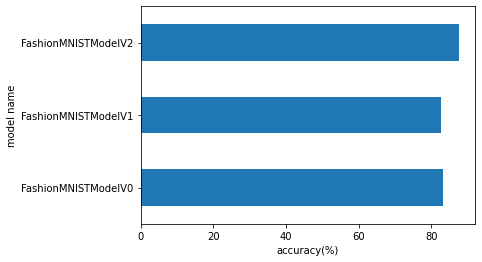

In [ ]:
compare_results.set_index("model_name")["model_acc"].plot(kind="barh")
plt.xlabel("accuracy(%)")
plt.ylabel("model name")